<h2> Credit: https://github.com/fitushar/3D-Grad-CAM/blob/master/3DGrad-CAM.ipynb </h2>

In [21]:
import tensorflow as tf
import os
import datetime
import numpy as np
import nibabel as nib 
import cv2
import matplotlib.pyplot as plt
from skimage.transform import resize
from matplotlib import pyplot as plt

In [22]:
Scans = [f.path for f in os.scandir("TestData")]
def loadDataSingle(subjs):
    tmp = []
    Y = []
    tmp.append(nib.load(subjs).get_fdata())
    if "HC" in subjs:
        Y.append([0,1])
    else:
        Y.append([1,0])
    tmp = np.asarray(tmp)
    tmp = (tmp-np.min(tmp))/(np.max(tmp)-np.min(tmp))
    return(tmp.reshape(216, 180, 216,1), np.asarray(Y))


In [23]:
#get Model
model = tf.keras.models.load_model('ModelSave_bin1B/modelB')
model.load_weights('tmpFolderBin1ModelB/weight15.h5')

In [15]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 216, 180, 216, 1  0         
                             )]                                  
                                                                 
 conv3d (Conv3D)             (None, 216, 180, 216, 8)  224       
                                                                 
 dropout (Dropout)           (None, 216, 180, 216, 8)  0         
                                                                 
 batch_normalization (BatchN  (None, 216, 180, 216, 8)  32       
 ormalization)                                                   
                                                                 
 conv3d_1 (Conv3D)           (None, 216, 180, 216, 8)  1736      
                                                                 
 batch_normalization_1 (Batc  (None, 216, 180, 216, 8)  32   

In [16]:
#get last conv layer
LAYER_NAME='conv3d_9'
# Create a graph that outputs target convolution and output
grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(LAYER_NAME).output, model.output])
grad_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 216, 180, 216, 1  0         
                             )]                                  
                                                                 
 conv3d (Conv3D)             (None, 216, 180, 216, 8)  224       
                                                                 
 dropout (Dropout)           (None, 216, 180, 216, 8)  0         
                                                                 
 batch_normalization (BatchN  (None, 216, 180, 216, 8)  32       
 ormalization)                                                   
                                                                 
 conv3d_1 (Conv3D)           (None, 216, 180, 216, 8)  1736      
                                                                 
 batch_normalization_1 (Batc  (None, 216, 180, 216, 8)  32 

In [17]:

TestSubjs = loadDataSingle(Scans[0])
CLASS_INDEX = np.argmax(TestSubjs[1])
print(CLASS_INDEX)
with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(np.asarray([TestSubjs[0]]))
    loss = predictions[:, CLASS_INDEX]

0


In [18]:
# Extract filters and gradients
output = conv_outputs[0]
grads = tape.gradient(loss, conv_outputs)[0]

In [19]:
# Average gradients spatially
weights = tf.reduce_mean(grads, axis=(0, 1,2))
# Build a ponderated map of filters according to gradients importance
cam = np.zeros(output.shape[0:3], dtype=np.float32)

for index, w in enumerate(weights):
    cam += w * output[:, :, :, index]
cam.shape

TensorShape([27, 22, 27])

[[1 0]]


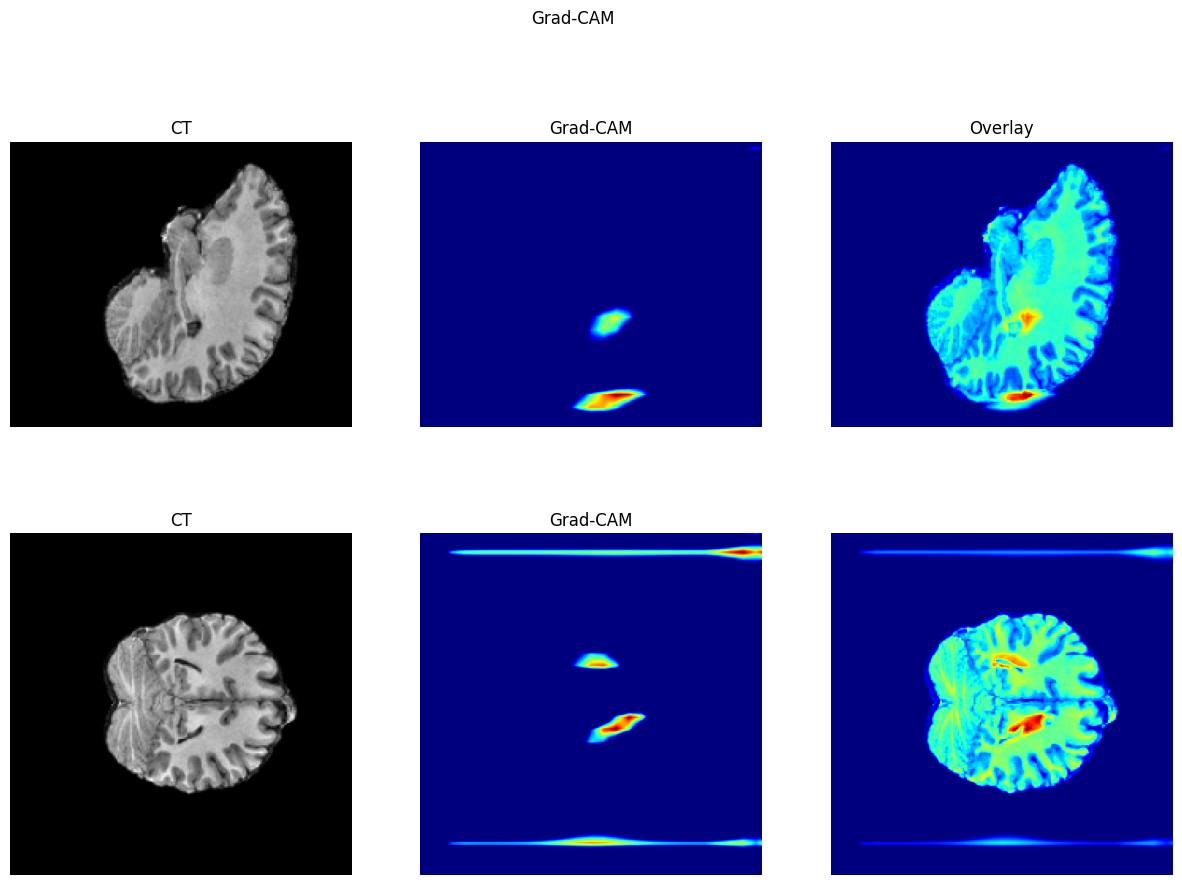

In [20]:

capi=resize(cam,(216, 180, 216))
#print(capi.shape)
capi = np.maximum(capi,0)
heatmap = (capi - capi.min()) / (capi.max() - capi.min())
f, axarr = plt.subplots(2,3,figsize=(15,10));
f.suptitle('Grad-CAM')

slice_count=127
slice_count2=120
    
axial_ct_img=np.squeeze(TestSubjs[0][slice_count, :,:])
axial_grad_cmap_img=np.squeeze(heatmap[slice_count,:, :])
axial_grad_cmap_img=axial_grad_cmap_img.astype('float64')

coronal_ct_img=np.squeeze(TestSubjs[0][:,slice_count2,:])
coronal_grad_cmap_img=np.squeeze(heatmap[:,slice_count2,:]) 
coronal_grad_cmap_img=coronal_grad_cmap_img.astype('float64')

img_plot = axarr[0,0].imshow(axial_ct_img, cmap='gray');
axarr[0,0].axis('off')
axarr[0,0].set_title('CT')
    
img_plot = axarr[0,1].imshow(axial_grad_cmap_img, cmap='jet');
axarr[0,1].axis('off')
axarr[0,1].set_title('Grad-CAM')
    
axial_overlay=cv2.addWeighted(axial_ct_img,0.3,axial_grad_cmap_img, 0.6, 0)
    
img_plot = axarr[0,2].imshow(axial_overlay,cmap='jet');
axarr[0,2].axis('off')
axarr[0,2].set_title('Overlay')


img_plot = axarr[1,0].imshow(coronal_ct_img, cmap='gray');
axarr[1,0].axis('off')
axarr[1,0].set_title('CT')
    
img_plot = axarr[1,1].imshow(coronal_grad_cmap_img, cmap='jet');
axarr[1,1].axis('off')
axarr[1,1].set_title('Grad-CAM')
    
Coronal_overlay=cv2.addWeighted(coronal_ct_img,0.3,coronal_grad_cmap_img, 0.6, 0)
    
img_plot = axarr[1,2].imshow(Coronal_overlay,cmap='jet');
axarr[1,2].axis('off')

print(TestSubjs[1])

[[0 1]]


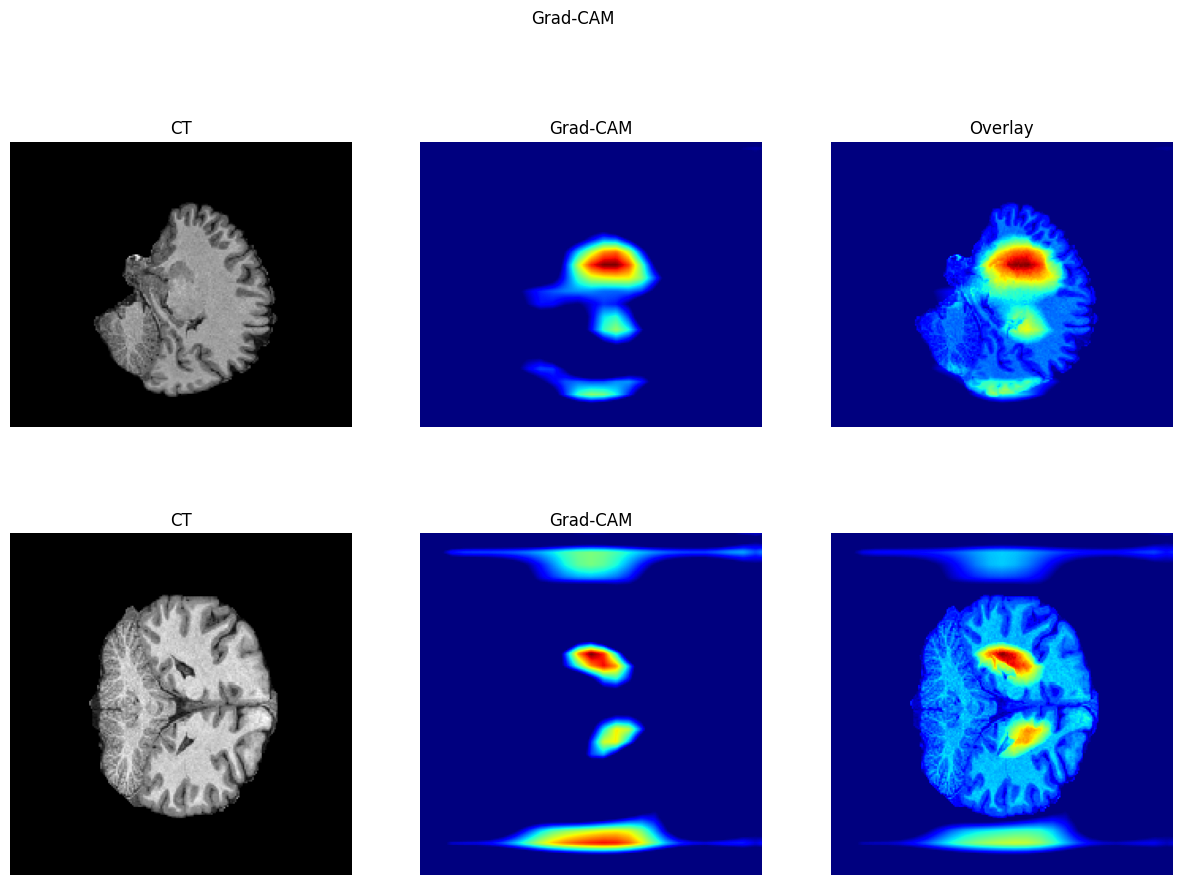

In [51]:
TestSubjs = loadDataSingle('TestData/HC393_lsq.nii.gz')
CLASS_INDEX = np.argmax(TestSubjs[1])
with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(np.asarray([TestSubjs[0]]))
    loss = predictions[:, CLASS_INDEX]
# Extract filters and gradients
output = conv_outputs[0]
grads = tape.gradient(loss, conv_outputs)[0]
# Average gradients spatially
weights = tf.reduce_mean(grads, axis=(0, 1,2))
# Build a ponderated map of filters according to gradients importance
cam = np.zeros(output.shape[0:3], dtype=np.float32)

for index, w in enumerate(weights):
    cam += w * output[:, :, :, index]
cam.shape
capi=resize(cam,(216, 180, 216))
#print(capi.shape)
capi = np.maximum(capi,0)
heatmap = (capi - capi.min()) / (capi.max() - capi.min())
f, axarr = plt.subplots(2,3,figsize=(15,10));
f.suptitle('Grad-CAM')

slice_count=127
slice_count2=120
    
axial_ct_img=np.squeeze(TestSubjs[0][slice_count, :,:])
axial_grad_cmap_img=np.squeeze(heatmap[slice_count,:, :])
axial_grad_cmap_img=axial_grad_cmap_img.astype('float64')

coronal_ct_img=np.squeeze(TestSubjs[0][:,slice_count2,:])
coronal_grad_cmap_img=np.squeeze(heatmap[:,slice_count2,:]) 
coronal_grad_cmap_img=coronal_grad_cmap_img.astype('float64')

img_plot = axarr[0,0].imshow(axial_ct_img, cmap='gray');
axarr[0,0].axis('off')
axarr[0,0].set_title('CT')
    
img_plot = axarr[0,1].imshow(axial_grad_cmap_img, cmap='jet');
axarr[0,1].axis('off')
axarr[0,1].set_title('Grad-CAM')
    
axial_overlay=cv2.addWeighted(axial_ct_img,0.3,axial_grad_cmap_img, 0.6, 0)
    
img_plot = axarr[0,2].imshow(axial_overlay,cmap='jet');
axarr[0,2].axis('off')
axarr[0,2].set_title('Overlay')


img_plot = axarr[1,0].imshow(coronal_ct_img, cmap='gray');
axarr[1,0].axis('off')
axarr[1,0].set_title('CT')
    
img_plot = axarr[1,1].imshow(coronal_grad_cmap_img, cmap='jet');
axarr[1,1].axis('off')
axarr[1,1].set_title('Grad-CAM')
    
Coronal_overlay=cv2.addWeighted(coronal_ct_img,0.3,coronal_grad_cmap_img, 0.6, 0)
    
img_plot = axarr[1,2].imshow(Coronal_overlay,cmap='jet');
axarr[1,2].axis('off')

print(TestSubjs[1])

0
[[1 0]]


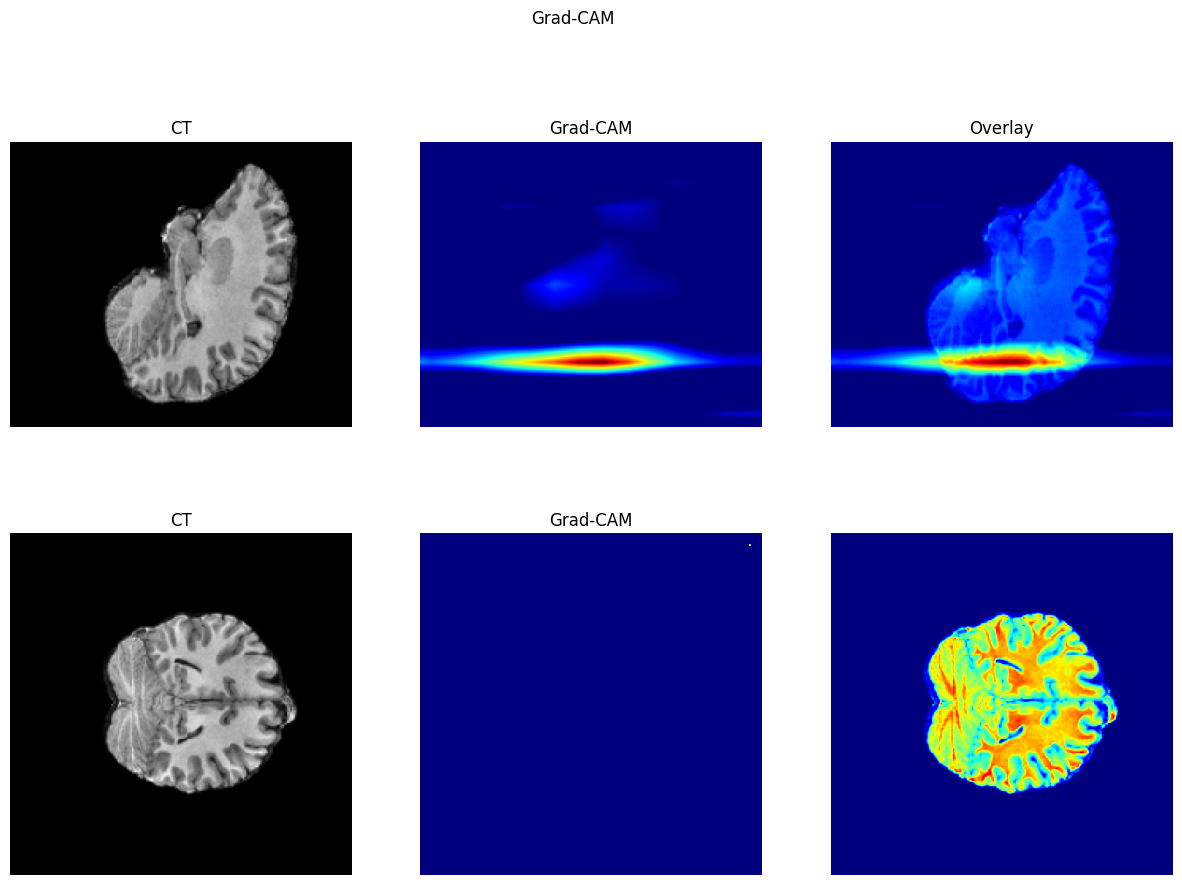

In [6]:
#get Model
model = tf.keras.models.load_model('ModelSave_bin_small1C/modelC')
model.load_weights('tmpFolderBin1ModelC/weight15.h5')
#get last conv layer
LAYER_NAME='conv3d_10'
# Create a graph that outputs target convolution and output
grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(LAYER_NAME).output, model.output])

TestSubjs = loadDataSingle(Scans[0])
CLASS_INDEX = np.argmax(TestSubjs[1])
print(CLASS_INDEX)
with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(np.asarray([TestSubjs[0]]))
    loss = predictions[:, CLASS_INDEX]
# Extract filters and gradients
output = conv_outputs[0]
grads = tape.gradient(loss, conv_outputs)[0]
# Average gradients spatially
weights = tf.reduce_mean(grads, axis=(0, 1,2))
# Build a ponderated map of filters according to gradients importance
cam = np.zeros(output.shape[0:3], dtype=np.float32)

for index, w in enumerate(weights):
    cam += w * output[:, :, :, index]
cam.shape
capi=resize(cam,(216, 180, 216))
#print(capi.shape)
capi = np.maximum(capi,0)
heatmap = (capi - capi.min()) / (capi.max() - capi.min())
f, axarr = plt.subplots(2,3,figsize=(15,10));
f.suptitle('Grad-CAM')

slice_count=127
slice_count2=120
    
axial_ct_img=np.squeeze(TestSubjs[0][slice_count, :,:])
axial_grad_cmap_img=np.squeeze(heatmap[slice_count,:, :])
axial_grad_cmap_img=axial_grad_cmap_img.astype('float64')

coronal_ct_img=np.squeeze(TestSubjs[0][:,slice_count2,:])
coronal_grad_cmap_img=np.squeeze(heatmap[:,slice_count2,:]) 
coronal_grad_cmap_img=coronal_grad_cmap_img.astype('float64')

img_plot = axarr[0,0].imshow(axial_ct_img, cmap='gray');
axarr[0,0].axis('off')
axarr[0,0].set_title('CT')
    
img_plot = axarr[0,1].imshow(axial_grad_cmap_img, cmap='jet');
axarr[0,1].axis('off')
axarr[0,1].set_title('Grad-CAM')
    
axial_overlay=cv2.addWeighted(axial_ct_img,0.3,axial_grad_cmap_img, 0.6, 0)
    
img_plot = axarr[0,2].imshow(axial_overlay,cmap='jet');
axarr[0,2].axis('off')
axarr[0,2].set_title('Overlay')


img_plot = axarr[1,0].imshow(coronal_ct_img, cmap='gray');
axarr[1,0].axis('off')
axarr[1,0].set_title('CT')
    
img_plot = axarr[1,1].imshow(coronal_grad_cmap_img, cmap='jet');
axarr[1,1].axis('off')
axarr[1,1].set_title('Grad-CAM')
    
Coronal_overlay=cv2.addWeighted(coronal_ct_img,0.3,coronal_grad_cmap_img, 0.6, 0)
    
img_plot = axarr[1,2].imshow(Coronal_overlay,cmap='jet');
axarr[1,2].axis('off')

print(TestSubjs[1])

1
[[0 1]]


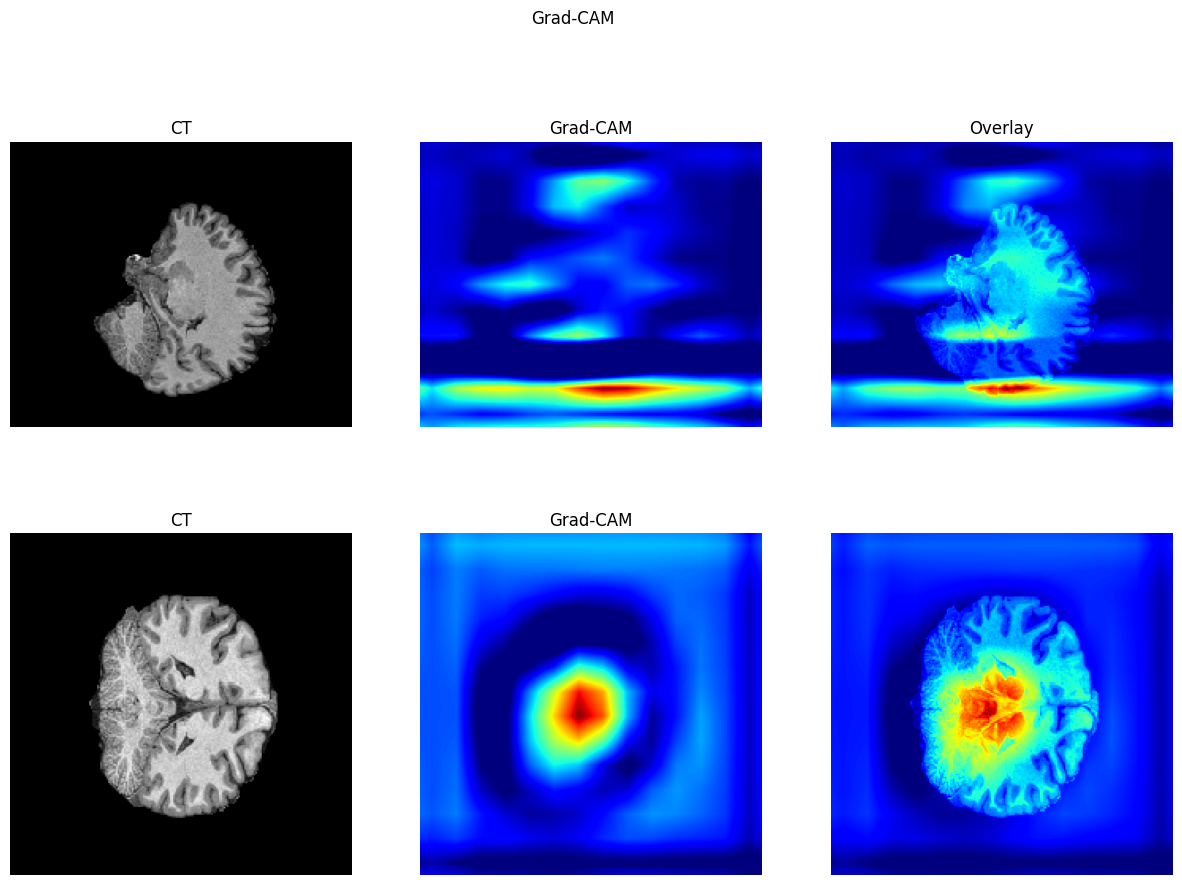

In [8]:
TestSubjs = loadDataSingle('TestData/HC393_lsq.nii.gz')
CLASS_INDEX = np.argmax(TestSubjs[1])
print(CLASS_INDEX)
with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(np.asarray([TestSubjs[0]]))
    loss = predictions[:, CLASS_INDEX]
# Extract filters and gradients
output = conv_outputs[0]
grads = tape.gradient(loss, conv_outputs)[0]
# Average gradients spatially
weights = tf.reduce_mean(grads, axis=(0, 1,2))
# Build a ponderated map of filters according to gradients importance
cam = np.zeros(output.shape[0:3], dtype=np.float32)

for index, w in enumerate(weights):
    cam += w * output[:, :, :, index]
cam.shape
capi=resize(cam,(216, 180, 216))
#print(capi.shape)
capi = np.maximum(capi,0)
heatmap = (capi - capi.min()) / (capi.max() - capi.min())
f, axarr = plt.subplots(2,3,figsize=(15,10));
f.suptitle('Grad-CAM')

slice_count=127
slice_count2=120
    
axial_ct_img=np.squeeze(TestSubjs[0][slice_count, :,:])
axial_grad_cmap_img=np.squeeze(heatmap[slice_count,:, :])
axial_grad_cmap_img=axial_grad_cmap_img.astype('float64')

coronal_ct_img=np.squeeze(TestSubjs[0][:,slice_count2,:])
coronal_grad_cmap_img=np.squeeze(heatmap[:,slice_count2,:]) 
coronal_grad_cmap_img=coronal_grad_cmap_img.astype('float64')

img_plot = axarr[0,0].imshow(axial_ct_img, cmap='gray');
axarr[0,0].axis('off')
axarr[0,0].set_title('CT')
    
img_plot = axarr[0,1].imshow(axial_grad_cmap_img, cmap='jet');
axarr[0,1].axis('off')
axarr[0,1].set_title('Grad-CAM')
    
axial_overlay=cv2.addWeighted(axial_ct_img,0.3,axial_grad_cmap_img, 0.6, 0)
    
img_plot = axarr[0,2].imshow(axial_overlay,cmap='jet');
axarr[0,2].axis('off')
axarr[0,2].set_title('Overlay')


img_plot = axarr[1,0].imshow(coronal_ct_img, cmap='gray');
axarr[1,0].axis('off')
axarr[1,0].set_title('CT')
    
img_plot = axarr[1,1].imshow(coronal_grad_cmap_img, cmap='jet');
axarr[1,1].axis('off')
axarr[1,1].set_title('Grad-CAM')
    
Coronal_overlay=cv2.addWeighted(coronal_ct_img,0.3,coronal_grad_cmap_img, 0.6, 0)
    
img_plot = axarr[1,2].imshow(Coronal_overlay,cmap='jet');
axarr[1,2].axis('off')

print(TestSubjs[1])

1
[[0 1]]


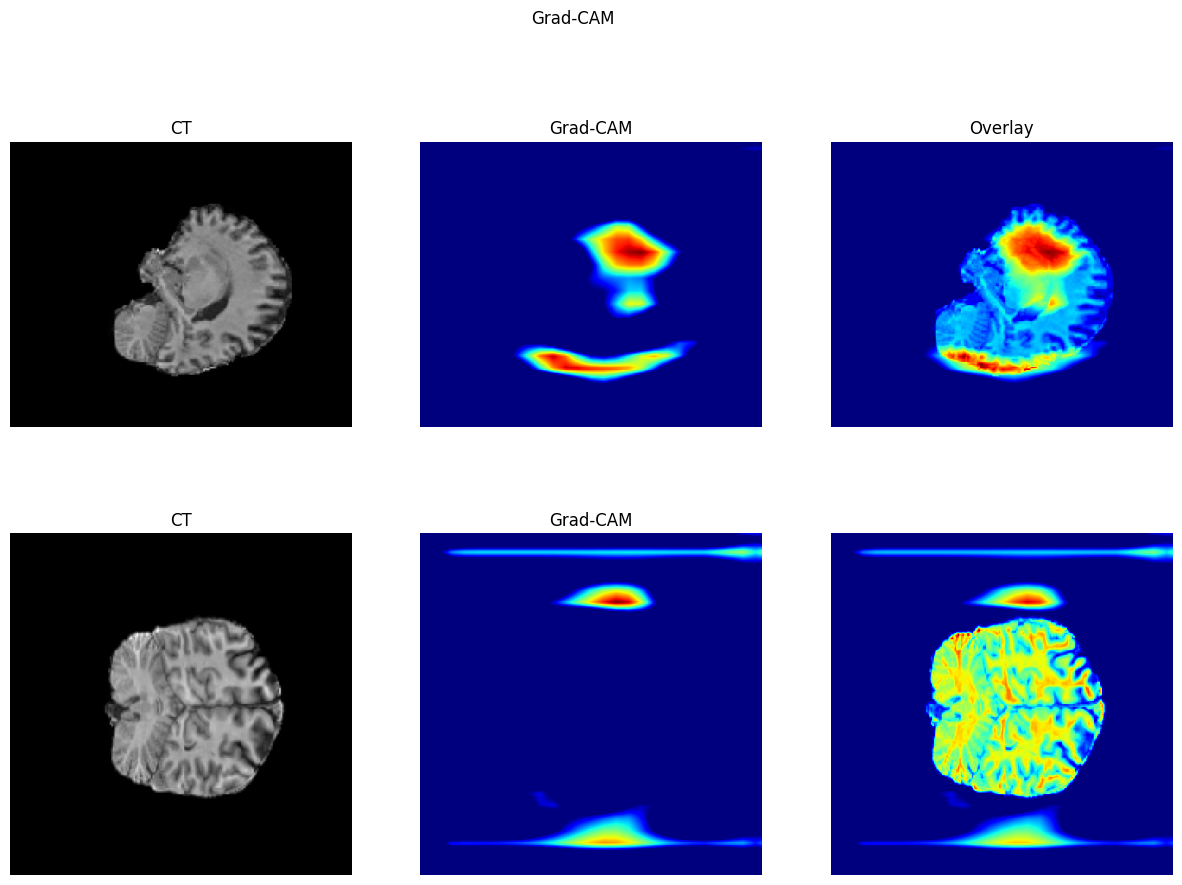

In [24]:
TestSubjs = loadDataSingle('TestData/HC403_lsq.nii.gz')
CLASS_INDEX = np.argmax(TestSubjs[1])
print(CLASS_INDEX)
with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(np.asarray([TestSubjs[0]]))
    loss = predictions[:, CLASS_INDEX]
# Extract filters and gradients
output = conv_outputs[0]
grads = tape.gradient(loss, conv_outputs)[0]
# Average gradients spatially
weights = tf.reduce_mean(grads, axis=(0, 1,2))
# Build a ponderated map of filters according to gradients importance
cam = np.zeros(output.shape[0:3], dtype=np.float32)

for index, w in enumerate(weights):
    cam += w * output[:, :, :, index]
cam.shape
capi=resize(cam,(216, 180, 216))
#print(capi.shape)
capi = np.maximum(capi,0)
heatmap = (capi - capi.min()) / (capi.max() - capi.min())
f, axarr = plt.subplots(2,3,figsize=(15,10));
f.suptitle('Grad-CAM')

slice_count=127
slice_count2=120
    
axial_ct_img=np.squeeze(TestSubjs[0][slice_count, :,:])
axial_grad_cmap_img=np.squeeze(heatmap[slice_count,:, :])
axial_grad_cmap_img=axial_grad_cmap_img.astype('float64')

coronal_ct_img=np.squeeze(TestSubjs[0][:,slice_count2,:])
coronal_grad_cmap_img=np.squeeze(heatmap[:,slice_count2,:]) 
coronal_grad_cmap_img=coronal_grad_cmap_img.astype('float64')

img_plot = axarr[0,0].imshow(axial_ct_img, cmap='gray');
axarr[0,0].axis('off')
axarr[0,0].set_title('CT')
    
img_plot = axarr[0,1].imshow(axial_grad_cmap_img, cmap='jet');
axarr[0,1].axis('off')
axarr[0,1].set_title('Grad-CAM')
    
axial_overlay=cv2.addWeighted(axial_ct_img,0.3,axial_grad_cmap_img, 0.6, 0)
    
img_plot = axarr[0,2].imshow(axial_overlay,cmap='jet');
axarr[0,2].axis('off')
axarr[0,2].set_title('Overlay')


img_plot = axarr[1,0].imshow(coronal_ct_img, cmap='gray');
axarr[1,0].axis('off')
axarr[1,0].set_title('CT')
    
img_plot = axarr[1,1].imshow(coronal_grad_cmap_img, cmap='jet');
axarr[1,1].axis('off')
axarr[1,1].set_title('Grad-CAM')
    
Coronal_overlay=cv2.addWeighted(coronal_ct_img,0.3,coronal_grad_cmap_img, 0.6, 0)
    
img_plot = axarr[1,2].imshow(Coronal_overlay,cmap='jet');
axarr[1,2].axis('off')

print(TestSubjs[1])